# Глубокое обучение и обработка естественного языка

## Домашняя работа №5

Загрузить набор данных Lenta.ru с помощью пакета Corus

1. Обучить LDA модель, постараться подобрать адекватные параметры (num_topics, passes, alpha, iterations…) - 4 балла
2. Визуализировать результаты работы LDA с помощью pyLDAvis - 2 балла
3. Посчитать внутренние метрики обученных моделей LDA (с разными параметрами) и сравнить, соответствует ли метрика визуальному качеству работы моделей - 2 балла
4. Обучить модель BigARTM, использовать не менее двух регуляризаторов, оценить качество с помощью метрик - 5 баллов
5. Реализовать визуализацию топиков BigARTM через pyLDAvis - 4 балла
6. Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - 2 балла
7. Соблюден code style на уровне pep8 и On writing clean Jupyter notebooks - 1 балл

**Примечание:** подбирать параметры теметической модели можно также, как и для любой другой модели - на кроссвалидации, ориентируясь на метрики качества

In [2]:
import pandas as pd
import numpy as np

In [2]:
!pip install corus pymorphy2 razdel pyLDAvis

In [ ]:
import re
from pprint import pprint
from collections import Counter
import itertools
from tqdm.notebook import tqdm
import warnings, logging


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

import nltk
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import razdel
from corus import load_lenta

import pymorphy2
from bs4 import BeautifulSoup

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
SEED = 2023

np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# функция, очистка от html разметки
def clean_html_bs4(text_data):
  soup = BeautifulSoup(text_data, 'lxml')
  return soup.get_text()

# функция, очистка от мусора, нормализация и лемматизация
def tokenize(text, stopwords, need_lemmatize=False):
  result = []
  sentences = [item.text for item in razdel.sentenize(str(text))]

  for sentence in sentences:
    text = sentence.lower()
    text = clean_html_bs4(text)
    text = re.sub(r"\s+", ' ', text)

    tokens = [item.text for item in  razdel.tokenize(text)]
    tokens = [re.sub("[^а-яА-Яa-zA-Z]", ' ', item) for item in tokens]

    if need_lemmatize:
      tokens = [analyzer.parse(token)[0].normal_form for token in tokens if token not in stopwords  and ' ' not in token and len(token) > 2]
      tokens = [token for token in tokens if token not in lemmatized_sw]
    tokens = [re.sub(r"ё", "е", token) for token in tokens]
    result.extend(tokens)
  return result

# функция получение сочетаний слов
def get_ngrams(texts_out):
    texts_out = [trigram[bigram[doc]] for doc in texts_out]
    return texts_out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Загрузка данных

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [8]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
dataset = [next(records).text for i in range(1000)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Предобработка

In [9]:
sw = stopwords.words('russian')
additional_sw =  'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

sw.extend(additional_sw.split())
sw.extend(pronouns.split())
sw.extend(conjunctions.split())
sw.extend(digits.split())
sw.extend(modal_words.split())
sw.extend(particles.split())
sw.extend(prepositions.split())
sw.extend(evaluative.split())
sw = list(set(sw))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Очистка от мусора, нормализация и лемматизация

In [ ]:
need_preprocess = True

if need_preprocess:
  analyzer = pymorphy2.MorphAnalyzer()
  lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]
  tokenized = [tokenize(text, stopwords=sw, need_lemmatize=True) for text in dataset]

Обнаружение сочетаний слов

In [ ]:
bigram = gensim.models.Phrases(tokenized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized], threshold=100)  # Phraser == FrozenPhrases
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
tokenized = get_ngrams(tokenized)

## Создание словаря

In [ ]:
id2word = corpora.Dictionary(tokenized)
corpus = [id2word.doc2bow(text) for text in tokenized]

## Модель LDA

In [86]:
models = []
# params =  {'num_topics': [4, 6, 8], 'chunksize': [1, 64],
#            'passes': [1, 100], 'alpha': ['symmetric'],
#            'iterations': [50, 150]}

params =  {'num_topics': [3, 4, 5, 6, 7, 8], 'chunksize': [1, 64], 'alpha': ['symmetric', 'auto']}

In [87]:
params = list(params.values())
params_tuples = []

for element in itertools.product(*params):
    params_tuples.append(element)

In [88]:
%%time

for params in tqdm(params_tuples):
  model = gensim.models.ldamodel.LdaModel(
      corpus=corpus,
      id2word=id2word,
      num_topics=params[0],
      random_state=SEED,
      chunksize=params[1],
      # passes=params[2],
      alpha=params[2],
      # iterations=params[4],
      per_word_topics=True,
  )
  models.append(model)

  0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 2min 59s, sys: 501 ms, total: 3min
Wall time: 3min 3s


## Метрики

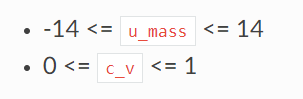

In [94]:
perplexity = np.zeros(len(models))
coherence_cv = np.zeros(len(models))
coherence_umass = np.zeros(len(models))

In [95]:
for i in range(len(models)):
  cm_umass = CoherenceModel(model=models[i], corpus=corpus, coherence='u_mass')
  cm_cv = CoherenceModel(model=models[i], texts=tokenized, coherence='c_v')

  perplexity[i] = model.log_perplexity(corpus)
  coherence_umass[i] = cm_umass.get_coherence()
  coherence_cv[i] = cm_cv.get_coherence()

In [96]:
print(perplexity)
print(perplexity.argmin())

[-9.60091406 -9.6009141  -9.60091408 -9.60091405 -9.60091397 -9.60091396
 -9.600914   -9.60091409 -9.60091408 -9.60091399 -9.60091399 -9.60091403
 -9.60091408 -9.60091399 -9.600914   -9.60091405 -9.6009141  -9.60091404
 -9.60091396 -9.60091401 -9.60091406 -9.60091395 -9.60091394 -9.600914  ]
1


Перплексия незначительно различается среди моделей

In [97]:
print(coherence_umass)
print(coherence_umass.argmax())

[-4.1029411  -3.2368754  -1.80834553 -1.77730325 -3.33515276 -3.03343124
 -2.05049295 -2.0420132  -3.35389492 -3.2995249  -2.47226503 -2.55822179
 -3.98637587 -3.72674939 -3.5269557  -3.49496879 -4.04133101 -4.21976563
 -3.52906184 -3.73488001 -4.73911072 -5.01365659 -4.4971581  -4.44763559]
3


Когеренция_umass наибольшая для модели 3

In [98]:
print(coherence_cv)
print(coherence_cv.argmax())

[0.34034298 0.34384493 0.33642255 0.33091302 0.29547499 0.27196326
 0.34977802 0.34526834 0.28427611 0.27462981 0.28696541 0.27528954
 0.24995087 0.25858893 0.30700818 0.29927827 0.26288427 0.26412417
 0.34100967 0.35102982 0.23445493 0.29857517 0.33643428 0.32819079]
19


Когеренция_cv незначительно различается среди моделей

In [104]:
params_tuples[3]

(3, 64, 'auto')

In [105]:
model = models[3]
pprint(model.print_topics())

[(0,
  '0.013*"год" + 0.008*"россия" + 0.008*"российский" + 0.006*"декабрь" + '
  '0.004*"человек" + 0.004*"сообщать" + 0.004*"слово" + 0.004*"стать" + '
  '0.004*"страна" + 0.004*"заявить"'),
 (1,
  '0.013*"год" + 0.010*"россия" + 0.005*"компания" + 0.005*"российский" + '
  '0.005*"страна" + 0.005*"украина" + 0.005*"слово" + 0.005*"заявить" + '
  '0.004*"процент" + 0.004*"украинский"'),
 (2,
  '0.007*"год" + 0.003*"женщина" + 0.003*"сообщать" + 0.003*"ребенок" + '
  '0.003*"стать" + 0.003*"мужчина" + 0.003*"фотография" + 0.003*"человек" + '
  '0.003*"дом" + 0.003*"пользователь"')]


## Визуализация

In [106]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030941 -0.103386       1        1  37.268633
1     -0.109027  0.070964       2        1  35.613880
2      0.139968  0.032422       3        1  27.117487, topic_info=              Term        Freq       Total Category  logprob  loglift
21          россия  721.000000  721.000000  Default  30.0000  30.0000
421        украина  215.000000  215.000000  Default  29.0000  29.0000
1361    украинский  173.000000  173.000000  Default  28.0000  28.0000
915       компания  256.000000  256.000000  Default  27.0000  27.0000
15         процент  198.000000  198.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
283          новый   60.153513  227.623179   Topic3  -6.1882  -0.0258
172   американский   56.127931  163.906814   Topic3  -6.2574   0.2333
282      несколько   52.217488  139.032746   Topic3  -6.3296   0.3257
37          тысяча   53.862119  196.831017   Topic3  -6.2986   0.0091
26           слово   55.170243  402.346345   Topic3  -6.2746  -0.6819

[258 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4950      1  0.038647        агрессия
4950      2  0.966174        агрессия
4950      3  0.038647        агрессия
172       1  0.512486    американский
172       2  0.146425    американский
...     ...       ...             ...
2892      2  0.942643       экономика
4003      1  0.059452           экран
4003      2  0.029726           экран
4003      3  0.921511           экран
1630      1  0.979827  этап_кубок_мир

[505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [107]:
!pip freeze > requirements.txt